In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io.wavfile
import scipy.signal
import matplotlib.pyplot as plt
import keras
from random import sample 
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LSTM
from keras.layers import TimeDistributed, Flatten, Dense, Reshape, Dropout
from keras.utils import multi_gpu_model
import tensorflow as tf

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [classes[i] for i in unique_labels(y_true, y_pred)]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [6]:
metadata = pd.read_csv('musicnet_metadata.csv')

In [7]:
metadata.groupby('composer').apply(len)

composer
Bach          67
Beethoven    157
Brahms        24
Cambini        9
Dvorak         8
Faure          4
Haydn          3
Mozart        24
Ravel          4
Schubert      30
dtype: int64

In [29]:
composers = ['Bach','Brahms','Mozart','Schubert']

In [8]:
piano = [metadata.iloc[i].loc['id']  for i in metadata.index \
         if 'piano' in metadata.iloc[i].loc['ensemble'].lower()]# and \
        #metadata.iloc[i].loc['composer'] in composers]

In [9]:
classes = eval(open('processed/labels.txt').read())
classes = {v:k for k,v in classes.items()}

In [10]:
''' SOURCE: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly '''
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,:,:,0] = (np.genfromtxt('processed/%d.csv' % ID, delimiter=','))
            # gdrive support only
            #X[i,:,:,0] = np.transpose(np.genfromtxt('processed/%s/%d.csv' % (str(ID)[0],ID), delimiter=','))

            # Store class
            y[i] = self.labels.loc[ID+1, 0]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
    
class STFTDataGenerator(DataGenerator):
    'Generates data for Keras'
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,:,:,0] = (np.genfromtxt('processed/%d.csv' % ID, delimiter=','))[:883,:]
            # gdrive support only
            #X[i,:,:,0] = np.transpose(np.genfromtxt('processed/%s/%d.csv' % (str(ID)[0],ID), delimiter=','))

            # Store class
            y[i] = self.labels.loc[ID+1, 0]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

class MFCCDataGenerator(DataGenerator):
    'Generates data for Keras'
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,:,:,0] = (np.genfromtxt('processed/%d.csv' % ID, delimiter=','))[:,-30:]
            # gdrive support only
            #X[i,:,:,0] = np.transpose(np.genfromtxt('processed/%s/%d.csv' % (str(ID)[0],ID), delimiter=','))

            # Store class
            y[i] = self.labels.loc[ID+1, 0]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [11]:
''' 
  Based on the Neural network architecture from: 

    Gianluca Micchi. A neural network for composer classification. 
    International Society for Music Information Retrieval Conference (ISMIR 2018), 2018, Paris, France. <hal-01879276>

  and Keras code from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
'''


#num_classes = len(composers)
num_classes = 10 # since Y ranges from 0 to 9, using them all

#labels = pd.read_csv('processed/labels.csv',index_col=0,header=None) # Labels
labels = pd.read_csv('processed/labels.csv').T
labels = labels.drop([labels.index[0]],axis=0)
labels.index = labels.index.astype(np.int64)

labels = labels[[(i in piano) for i in labels[1]]]

#indices = list(labels.index[labels[1]!=1]-1)
#indices = range(1,labels.shape[0] +1)
indices = list(labels.index -1)

DATASET_SIZE = len(indices)
TRAIN_SIZE = int(.8*DATASET_SIZE)

In [ ]:
trainIDs = sample(indices, TRAIN_SIZE)
valIDs = [i for i in indices if i not in trainIDs]
testIDs = sample(valIDs, int(.5*len(valIDs)))
valIDs = [i for i in valIDs if i not in testIDs]


In [13]:
str_ids = open('cnn_lstm_split.txt')
(trainIDs,valIDs,testIDs) = eval(str_ids.read())
str_ids.close()

In [14]:

# Datasets
partition = {'train': trainIDs, 'validation': valIDs, 'test': testIDs} # IDs

First model - Mel spectrum

In [101]:
#MFCC First
# Parameters
params = {'dim': (1723,30),
          'batch_size': 128,
          'n_classes': num_classes,
          'n_channels': 1,
          'shuffle': True}


# Generators
training_generator = MFCCDataGenerator(partition['train'], labels, **params)
validation_generator = MFCCDataGenerator(partition['validation'], labels, **params)
testing_generator = MFCCDataGenerator(partition['test'], labels, **params)

In [104]:
# Design model

with tf.device('/cpu:0'):
    model = Sequential()

    model.add(Conv2D(16, (16, 8), input_shape = (1723, 30, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(.3))

    model.add(Conv2D(16, (16, 8), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(.3))

    model.add(Conv2D(16, (16, 8), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(BatchNormalization())

    model.add(Reshape([44,9*16]))

    model.add(LSTM(num_classes, return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(num_classes))

    model.add(Dense(num_classes))
    model.add(Dropout(.1))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss='categorical_crossentropy',
                       metrics=['acc'], optimizer='adam')

In [105]:
# Train model on dataset
historyMFCC = parallel_model.fit_generator(generator=training_generator, epochs=100,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=10)

Epoch 1/100
20/20 [==============================] - 146s 7s/step - loss: 2.0888 - acc: 0.4293 - val_loss: 2.0765 - val_acc: 0.4570
Epoch 2/100
20/20 [==============================] - 136s 7s/step - loss: 1.6744 - acc: 0.6062 - val_loss: 1.7700 - val_acc: 0.4609
Epoch 3/100
20/20 [==============================] - 139s 7s/step - loss: 1.3995 - acc: 0.6078 - val_loss: 1.9898 - val_acc: 0.3359
Epoch 4/100
Epoch 3/100
20/20 [==============================] - 139s 7s/step - loss: 1.2509 - acc: 0.6180 - val_loss: 2.5721 - val_acc: 0.0938
Epoch 5/100
20/20 [==============================] - 135s 7s/step - loss: 1.1466 - acc: 0.6414 - val_loss: 1.7462 - val_acc: 0.3438
Epoch 6/100
20/20 [==============================] - 132s 7s/step - loss: 1.0913 - acc: 0.6371 - val_loss: 2.1093 - val_acc: 0.2656
Epoch 7/100
20/20 [==============================] - 136s 7s/step - loss: 1.0437 - acc: 0.6484 - val_loss: 1.1325 - val_acc: 0.6055
Epoch 8/100
20/20 [==============================] - 136s 7s/ste

In [106]:
y_test = []
y_pred = []
for i in range(len(validation_generator)):
    x_test, y_test_ = validation_generator[i]
    y_pred_ = parallel_model.predict(x_test)
    y_test.append(y_test_.argmax(axis=1))
    y_pred.append(y_pred_.argmax(axis=1))
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

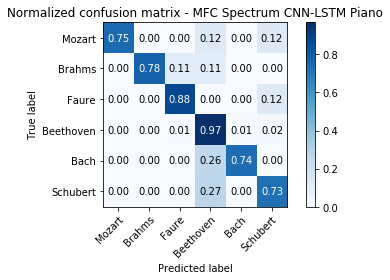

In [107]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=classes,
                      title='Normalized confusion matrix - MFC Spectrum CNN-LSTM Piano')

plt.show()

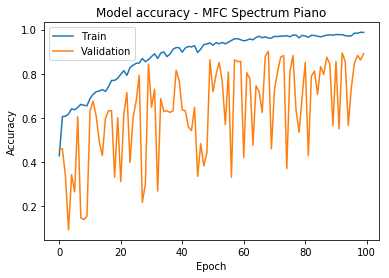

In [108]:
# Plot training & validation accuracy values
plt.plot(historyMFCC.history['acc'])
plt.plot(historyMFCC.history['val_acc'])
plt.title('Model accuracy - MFC Spectrum Piano')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

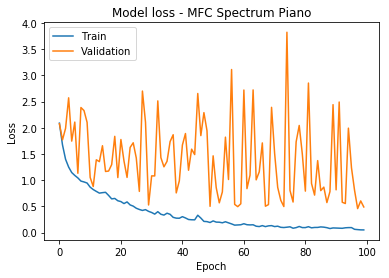

In [111]:
# Plot training & validation accuracy values
plt.plot(historyMFCC.history['loss'])
plt.plot(historyMFCC.history['val_loss'])
plt.title('Model loss - MFC Spectrum Piano')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [110]:
y_test = []
y_pred = []
for i in range(len(testing_generator)):
    x_test, y_test_ = testing_generator[i]
    y_pred_ = parallel_model.predict(x_test)
    y_test.append(y_test_.argmax(axis=1))
    y_pred.append(y_pred_.argmax(axis=1))
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
accuracy_score(y_test,y_pred)

0.875

In [15]:
from sklearn.metrics import classification_report

In [118]:
classes

{0: 'Mozart',
 1: 'Brahms',
 2: 'Faure',
 3: 'Beethoven',
 4: 'Dvorak',
 5: 'Haydn',
 6: 'Bach',
 7: 'Cambini',
 8: 'Schubert',
 9: 'Ravel'}

In [121]:
print(classification_report(y_test,y_pred,target_names=[classes[i] for i in unique_labels(y_test, y_pred)]))

              precision    recall  f1-score   support

      Mozart       0.90      1.00      0.95         9
      Brahms       1.00      0.85      0.92        13
       Faure       0.92      0.92      0.92        13
   Beethoven       0.86      0.97      0.91       158
        Bach       1.00      0.54      0.70        13
    Schubert       0.86      0.62      0.72        50

   micro avg       0.88      0.88      0.88       256
   macro avg       0.92      0.82      0.85       256
weighted avg       0.88      0.88      0.87       256



In [ ]:
parallel_model.save('mfcc_cnn_lstm.hd5')

In [122]:
diffIDs = str((trainIDs,valIDs,testIDs))
f = open('cnn_lstm_split.txt','w')
f.write(diffIDs)
f.close()

In [123]:
diffIDs

'([1884, 3525, 759, 1451, 2422, 1338, 303, 1165, 3334, 4595, 689, 4339, 5653, 3426, 4138, 1699, 2256, 3487, 4778, 762, 1483, 1768, 5181, 3128, 2904, 345, 5467, 2918, 919, 2405, 5335, 3343, 1651, 299, 3629, 3774, 1294, 1324, 5282, 1443, 3735, 2420, 5736, 916, 5062, 2805, 3561, 3727, 1540, 5442, 2620, 1432, 1596, 4960, 2095, 3088, 75, 3318, 2441, 2979, 4180, 2049, 2607, 5473, 3388, 1280, 4318, 624, 3536, 4614, 3565, 1938, 2087, 2745, 485, 3857, 5138, 5937, 982, 5036, 3230, 1410, 5005, 3109, 2806, 4951, 4446, 5233, 1473, 1401, 1727, 3355, 2765, 3985, 1527, 1717, 5521, 2744, 1360, 2017, 4190, 2674, 5647, 3340, 3219, 3879, 3763, 4505, 4124, 1529, 2274, 2997, 2309, 1335, 4764, 2756, 68, 1721, 1186, 3156, 1851, 1197, 3539, 2258, 5659, 344, 2671, 3573, 3107, 5352, 2917, 5890, 1202, 3523, 1450, 3177, 3981, 5077, 2170, 3149, 719, 4148, 5061, 5141, 3183, 5274, 5968, 2526, 1219, 2409, 3111, 4900, 1411, 5078, 3265, 5342, 884, 2330, 2439, 1341, 3126, 4954, 3795, 3739, 3975, 823, 5270, 3672, 2276, 13

Second model - cropped image

In [16]:
# Parameters
params = {'dim': (883,233),
          'batch_size': 128,
          'n_classes': num_classes,
          'n_channels': 1,
          'shuffle': True}



# Generators
training_generator = STFTDataGenerator(partition['train'], labels, **params)
validation_generator = STFTDataGenerator(partition['validation'], labels, **params)
testing_generator = STFTDataGenerator(partition['test'], labels, **params)

In [22]:
# Design model

with tf.device('/cpu:0'):
    model = Sequential()

    model.add(Conv2D(16, (16, 8), input_shape = (883, 233, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(.3))

    model.add(Conv2D(16, (16, 8), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(.3))

    model.add(Conv2D(16, (16, 8), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(BatchNormalization())

    model.add(Reshape([8,23*16]))

    model.add(LSTM(num_classes, return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(num_classes))

    model.add(Dense(num_classes))
    model.add(Dropout(.1))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss='categorical_crossentropy',
                       metrics=['acc'], optimizer='adam')

In [23]:
# Train model on dataset
historySTFT = parallel_model.fit_generator(generator=training_generator, epochs=100,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=16)

Epoch 1/100
20/20 [==============================] - 188s 9s/step - loss: 1.9071 - acc: 0.5375 - val_loss: 1.7096 - val_acc: 0.5859
Epoch 2/100
20/20 [==============================] - 109s 5s/step - loss: 1.6077 - acc: 0.5793 - val_loss: 1.4452 - val_acc: 0.5742
Epoch 3/100
20/20 [==============================] - 107s 5s/step - loss: 1.3855 - acc: 0.5840 - val_loss: 1.2116 - val_acc: 0.6094
Epoch 4/100
20/20 [==============================] - 110s 5s/step - loss: 1.2512 - acc: 0.5930 - val_loss: 1.2327 - val_acc: 0.5859
Epoch 5/100
20/20 [==============================] - 108s 5s/step - loss: 1.1832 - acc: 0.5902 - val_loss: 1.1859 - val_acc: 0.5898
Epoch 6/100
20/20 [==============================] - 112s 6s/step - loss: 1.1149 - acc: 0.6051 - val_loss: 1.2170 - val_acc: 0.5703
Epoch 7/100
20/20 [==============================] - 111s 6s/step - loss: 1.1186 - acc: 0.6074 - val_loss: 1.0742 - val_acc: 0.6367
Epoch 8/100
20/20 [==============================] - 116s 6s/step - loss: 1.

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.495012). Check your callbacks.
  % delta_t_median)
/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248043). Check your callbacks.
  % delta_t_median)


20/20 [==============================] - 113s 6s/step - loss: 0.0237 - acc: 0.9953 - val_loss: 0.4246 - val_acc: 0.9180
Epoch 89/100
20/20 [==============================] - 110s 6s/step - loss: 0.0196 - acc: 0.9961 - val_loss: 0.3876 - val_acc: 0.9258
Epoch 90/100
20/20 [==============================] - 111s 6s/step - loss: 0.0345 - acc: 0.9895 - val_loss: 0.6575 - val_acc: 0.8906
Epoch 91/100
20/20 [==============================] - 112s 6s/step - loss: 0.0469 - acc: 0.9863 - val_loss: 0.5240 - val_acc: 0.9062
Epoch 92/100
20/20 [==============================] - 110s 6s/step - loss: 0.0404 - acc: 0.9902 - val_loss: 0.5940 - val_acc: 0.8242
Epoch 93/100
20/20 [==============================] - 110s 5s/step - loss: 0.0277 - acc: 0.9945 - val_loss: 0.4360 - val_acc: 0.9102
Epoch 94/100
20/20 [==============================] - 110s 5s/step - loss: 0.0154 - acc: 0.9973 - val_loss: 0.4263 - val_acc: 0.9258
Epoch 95/100
20/20 [==============================] - 116s 6s/step - loss: 0.0264 

In [24]:
y_test = []
y_pred = []
for i in range(len(validation_generator)):
    x_test, y_test_ = validation_generator[i]
    y_pred_ = parallel_model.predict(x_test)
    y_test.append(y_test_.argmax(axis=1))
    y_pred.append(y_pred_.argmax(axis=1))
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

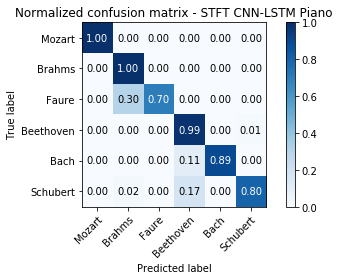

In [25]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=classes,
                      title='Normalized confusion matrix - STFT CNN-LSTM Piano')

plt.show()

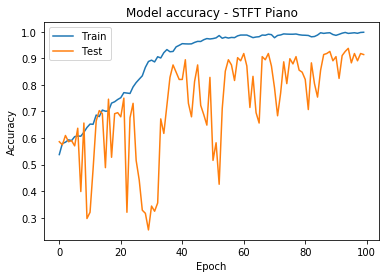

In [27]:
# Plot training & validation accuracy values
plt.plot(historySTFT.history['acc'])
plt.plot(historySTFT.history['val_acc'])
plt.title('Model accuracy - STFT Piano')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

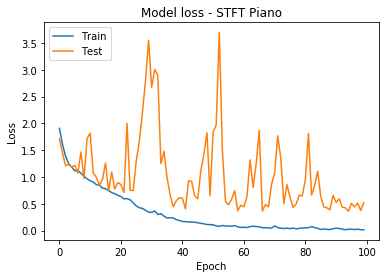

In [28]:
# Plot training & validation accuracy values
plt.plot(historySTFT.history['loss'])
plt.plot(historySTFT.history['val_loss'])
plt.title('Model loss - STFT Piano')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
y_test = []
y_pred = []
for i in range(len(testing_generator)):
    x_test, y_test_ = testing_generator[i]
    y_pred_ = parallel_model.predict(x_test)
    y_test.append(y_test_.argmax(axis=1))
    y_pred.append(y_pred_.argmax(axis=1))
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

In [31]:
from sklearn.metrics import accuracy_score, classification_report

In [32]:
accuracy_score(y_test,y_pred)

0.94921875

In [33]:
print(classification_report(y_test,y_pred,target_names=[classes[i] for i in unique_labels(y_test, y_pred)]))

              precision    recall  f1-score   support

      Mozart       1.00      1.00      1.00         6
      Brahms       0.93      0.93      0.93        15
       Faure       1.00      0.92      0.96        12
   Beethoven       0.96      0.97      0.96       156
        Bach       0.82      1.00      0.90        14
    Schubert       0.94      0.89      0.91        53

   micro avg       0.95      0.95      0.95       256
   macro avg       0.94      0.95      0.95       256
weighted avg       0.95      0.95      0.95       256



In [34]:
parallel_model.save('stft_cnn_lstm.hd5')

Last model - full image

In [35]:
# Parameters
params = {'dim': (1723,233),
          'batch_size': 64,
          'n_classes': num_classes,
          'n_channels': 1,
          'shuffle': True}



# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)
testing_generator = DataGenerator(partition['test'], labels, **params)

In [36]:
# Design model

with tf.device('/cpu:0'):
    model = Sequential()

    model.add(Conv2D(16, (16, 8), input_shape = (1723, 233, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(.3))

    model.add(Conv2D(16, (16, 8), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(.3))

    model.add(Conv2D(16, (16, 8), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(BatchNormalization())

    model.add(Reshape([22,23*16]))

    model.add(LSTM(num_classes, return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(num_classes))

    model.add(Dense(num_classes))
    model.add(Dropout(.1))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss='categorical_crossentropy',
                       metrics=['acc'], optimizer='adam')

In [37]:
# Train model on dataset
historyMIX = parallel_model.fit_generator(generator=training_generator, epochs=100,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=16)

Epoch 1/100
40/40 [==============================] - 235s 6s/step - loss: 1.7847 - acc: 0.5383 - val_loss: 1.4804 - val_acc: 0.6000
Epoch 2/100
40/40 [==============================] - 213s 5s/step - loss: 1.3738 - acc: 0.5789 - val_loss: 1.9863 - val_acc: 0.2938
Epoch 3/100
40/40 [==============================] - 215s 5s/step - loss: 1.2400 - acc: 0.5852 - val_loss: 1.6092 - val_acc: 0.5125
Epoch 4/100
40/40 [==============================] - 218s 5s/step - loss: 1.1518 - acc: 0.5781 - val_loss: 1.9588 - val_acc: 0.2281
Epoch 5/100
40/40 [==============================] - 214s 5s/step - loss: 1.0952 - acc: 0.6082 - val_loss: 1.8480 - val_acc: 0.2656
Epoch 6/100
40/40 [==============================] - 219s 5s/step - loss: 1.0321 - acc: 0.6172 - val_loss: 1.1693 - val_acc: 0.5813
Epoch 7/100
 1/40 [..............................] - ETA: 42:34 - loss: 0.7635 - acc: 0.7500

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.476200). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 214s 5s/step - loss: 0.9931 - acc: 0.6398 - val_loss: 1.7009 - val_acc: 0.3625
Epoch 8/100
40/40 [==============================] - 217s 5s/step - loss: 0.9566 - acc: 0.6516 - val_loss: 1.1349 - val_acc: 0.6312
Epoch 9/100
 4/40 [==>...........................] - ETA: 10:01 - loss: 0.8684 - acc: 0.6641

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.406261). Check your callbacks.
  % delta_t_median)


 5/40 [==>...........................] - ETA: 7:55 - loss: 0.8930 - acc: 0.6469 

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257189). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 214s 5s/step - loss: 0.8824 - acc: 0.6664 - val_loss: 0.8617 - val_acc: 0.7000
Epoch 10/100
40/40 [==============================] - 216s 5s/step - loss: 0.8570 - acc: 0.6766 - val_loss: 1.4070 - val_acc: 0.4562
Epoch 11/100
40/40 [==============================] - 214s 5s/step - loss: 0.8394 - acc: 0.6773 - val_loss: 1.7044 - val_acc: 0.3406
Epoch 12/100
40/40 [==============================] - 219s 5s/step - loss: 0.8100 - acc: 0.6840 - val_loss: 1.1607 - val_acc: 0.6719
Epoch 13/100
40/40 [==============================] - 220s 5s/step - loss: 0.7715 - acc: 0.6984 - val_loss: 0.6624 - val_acc: 0.7562
Epoch 14/100
40/40 [==============================] - 217s 5s/step - loss: 0.7146 - acc: 0.7219 - val_loss: 2.1748 - val_acc: 0.1531
Epoch 15/100
40/40 [==============================] - 213s 5s/step - loss: 0.7125 - acc: 0.7141 - val_loss: 2.1845 - val_acc: 0.1500
Epoch 16/100
40/40 [==============================] - 215s 5s/step - loss: 0.7062 

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.307635). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 215s 5s/step - loss: 0.4919 - acc: 0.7855 - val_loss: 0.7780 - val_acc: 0.6687
Epoch 24/100
40/40 [==============================] - 216s 5s/step - loss: 0.4723 - acc: 0.8082 - val_loss: 0.5014 - val_acc: 0.7531
Epoch 25/100
 1/40 [..............................] - ETA: 45:00 - loss: 0.5644 - acc: 0.7188

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.477774). Check your callbacks.
  % delta_t_median)


 3/40 [=>............................] - ETA: 14:34 - loss: 0.4618 - acc: 0.8073

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.371026). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 219s 5s/step - loss: 0.4200 - acc: 0.8406 - val_loss: 1.2781 - val_acc: 0.5125
Epoch 26/100
40/40 [==============================] - 221s 6s/step - loss: 0.4113 - acc: 0.8625 - val_loss: 2.0260 - val_acc: 0.2719
Epoch 27/100
40/40 [==============================] - 217s 5s/step - loss: 0.3836 - acc: 0.8668 - val_loss: 0.5176 - val_acc: 0.8438
Epoch 28/100
40/40 [==============================] - 220s 5s/step - loss: 0.3593 - acc: 0.8789 - val_loss: 2.9728 - val_acc: 0.0906
Epoch 29/100
40/40 [==============================] - 219s 5s/step - loss: 0.3433 - acc: 0.8930 - val_loss: 1.1102 - val_acc: 0.6969
Epoch 30/100
40/40 [==============================] - 218s 5s/step - loss: 0.3220 - acc: 0.8957 - val_loss: 0.9037 - val_acc: 0.6813
Epoch 31/100
40/40 [==============================] - 211s 5s/step - loss: 0.2910 - acc: 0.8973 - val_loss: 0.4195 - val_acc: 0.8875
Epoch 32/100
40/40 [==============================] - 221s 6s/step - loss: 0.2651 

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.819862). Check your callbacks.
  % delta_t_median)


 2/40 [>.............................] - ETA: 21:49 - loss: 0.0416 - acc: 0.9922

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.410569). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 218s 5s/step - loss: 0.0773 - acc: 0.9836 - val_loss: 0.5668 - val_acc: 0.8719
Epoch 46/100
40/40 [==============================] - 213s 5s/step - loss: 0.1004 - acc: 0.9750 - val_loss: 0.4587 - val_acc: 0.8781
Epoch 47/100
40/40 [==============================] - 218s 5s/step - loss: 0.1184 - acc: 0.9641 - val_loss: 2.9405 - val_acc: 0.2281
Epoch 48/100
40/40 [==============================] - 216s 5s/step - loss: 0.1167 - acc: 0.9676 - val_loss: 0.4320 - val_acc: 0.9125
Epoch 49/100
40/40 [==============================] - 221s 6s/step - loss: 0.0734 - acc: 0.9813 - val_loss: 0.7717 - val_acc: 0.8438
Epoch 50/100
 1/40 [..............................] - ETA: 42:58 - loss: 0.1517 - acc: 0.9844

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.453435). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 218s 5s/step - loss: 0.1077 - acc: 0.9703 - val_loss: 0.4652 - val_acc: 0.8938
Epoch 51/100
40/40 [==============================] - 214s 5s/step - loss: 0.0683 - acc: 0.9816 - val_loss: 0.3375 - val_acc: 0.9094
Epoch 52/100
40/40 [==============================] - 220s 6s/step - loss: 0.0956 - acc: 0.9766 - val_loss: 2.2830 - val_acc: 0.3750
Epoch 53/100
40/40 [==============================] - 219s 5s/step - loss: 0.1064 - acc: 0.9711 - val_loss: 1.5238 - val_acc: 0.7688
Epoch 54/100
40/40 [==============================] - 220s 6s/step - loss: 0.0808 - acc: 0.9746 - val_loss: 0.5943 - val_acc: 0.8781
Epoch 55/100
40/40 [==============================] - 216s 5s/step - loss: 0.0717 - acc: 0.9844 - val_loss: 0.7854 - val_acc: 0.8562
Epoch 56/100
40/40 [==============================] - 212s 5s/step - loss: 0.0493 - acc: 0.9887 - val_loss: 0.3643 - val_acc: 0.9156
Epoch 57/100
40/40 [==============================] - 217s 5s/step - loss: 0.0565 

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.469416). Check your callbacks.
  % delta_t_median)


 2/40 [>.............................] - ETA: 20:33 - loss: 0.0182 - acc: 1.0000

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.483320). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 214s 5s/step - loss: 0.0356 - acc: 0.9906 - val_loss: 0.8068 - val_acc: 0.8531
Epoch 61/100
40/40 [==============================] - 213s 5s/step - loss: 0.0320 - acc: 0.9937 - val_loss: 0.4623 - val_acc: 0.9094
Epoch 62/100
40/40 [==============================] - 220s 5s/step - loss: 0.0418 - acc: 0.9898 - val_loss: 0.5055 - val_acc: 0.8688
Epoch 63/100
40/40 [==============================] - 214s 5s/step - loss: 0.0444 - acc: 0.9871 - val_loss: 0.5033 - val_acc: 0.9031
Epoch 64/100
40/40 [==============================] - 214s 5s/step - loss: 0.0498 - acc: 0.9883 - val_loss: 0.3634 - val_acc: 0.9000
Epoch 65/100
40/40 [==============================] - 220s 5s/step - loss: 0.0486 - acc: 0.9867 - val_loss: 1.1556 - val_acc: 0.8406
Epoch 66/100
40/40 [==============================] - 212s 5s/step - loss: 0.0436 - acc: 0.9883 - val_loss: 0.6068 - val_acc: 0.8906
Epoch 67/100
 1/40 [..............................] - ETA: 44:35 - loss: 0.0562 - 

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.653170). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 220s 5s/step - loss: 0.0673 - acc: 0.9813 - val_loss: 3.2391 - val_acc: 0.3250
Epoch 68/100
40/40 [==============================] - 218s 5s/step - loss: 0.0639 - acc: 0.9801 - val_loss: 0.5135 - val_acc: 0.8875
Epoch 69/100
40/40 [==============================] - 213s 5s/step - loss: 0.0666 - acc: 0.9809 - val_loss: 0.4151 - val_acc: 0.9031
Epoch 70/100
40/40 [==============================] - 215s 5s/step - loss: 0.0547 - acc: 0.9859 - val_loss: 0.6549 - val_acc: 0.8844
Epoch 71/100
40/40 [==============================] - 215s 5s/step - loss: 0.0313 - acc: 0.9922 - val_loss: 1.4311 - val_acc: 0.6844
Epoch 72/100
40/40 [==============================] - 213s 5s/step - loss: 0.0474 - acc: 0.9875 - val_loss: 2.4215 - val_acc: 0.5563
Epoch 73/100
40/40 [==============================] - 214s 5s/step - loss: 0.0709 - acc: 0.9832 - val_loss: 0.5916 - val_acc: 0.8781
Epoch 74/100
40/40 [==============================] - 215s 5s/step - loss: 0.0611 

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.503298). Check your callbacks.
  % delta_t_median)


 2/40 [>.............................] - ETA: 21:22 - loss: 0.0146 - acc: 1.0000

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.518124). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 217s 5s/step - loss: 0.0346 - acc: 0.9922 - val_loss: 1.9054 - val_acc: 0.6188
Epoch 76/100
40/40 [==============================] - 213s 5s/step - loss: 0.0312 - acc: 0.9918 - val_loss: 1.6806 - val_acc: 0.6219
Epoch 77/100
40/40 [==============================] - 215s 5s/step - loss: 0.0317 - acc: 0.9898 - val_loss: 0.4092 - val_acc: 0.9156
Epoch 78/100
40/40 [==============================] - 212s 5s/step - loss: 0.0269 - acc: 0.9945 - val_loss: 0.4801 - val_acc: 0.8969
Epoch 79/100
40/40 [==============================] - 215s 5s/step - loss: 0.0361 - acc: 0.9922 - val_loss: 0.7955 - val_acc: 0.8625
Epoch 80/100
40/40 [==============================] - 215s 5s/step - loss: 0.0278 - acc: 0.9934 - val_loss: 0.9029 - val_acc: 0.8625
Epoch 81/100
40/40 [==============================] - 214s 5s/step - loss: 0.0292 - acc: 0.9930 - val_loss: 0.7448 - val_acc: 0.8625
Epoch 82/100
40/40 [==============================] - 214s 5s/step - loss: 0.0446 

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.563860). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 218s 5s/step - loss: 0.0394 - acc: 0.9875 - val_loss: 0.5177 - val_acc: 0.8938
Epoch 86/100
40/40 [==============================] - 213s 5s/step - loss: 0.0143 - acc: 0.9973 - val_loss: 0.5746 - val_acc: 0.8938
Epoch 87/100
40/40 [==============================] - 216s 5s/step - loss: 0.0317 - acc: 0.9930 - val_loss: 1.7710 - val_acc: 0.6375
Epoch 88/100
 3/40 [=>............................] - ETA: 13:33 - loss: 0.0138 - acc: 1.0000

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.380159). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 213s 5s/step - loss: 0.0367 - acc: 0.9906 - val_loss: 1.3623 - val_acc: 0.7188
Epoch 89/100
40/40 [==============================] - 218s 5s/step - loss: 0.0278 - acc: 0.9926 - val_loss: 0.5895 - val_acc: 0.8719
Epoch 90/100
 1/40 [..............................] - ETA: 42:34 - loss: 0.0063 - acc: 1.0000

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.542701). Check your callbacks.
  % delta_t_median)


 2/40 [>.............................] - ETA: 21:00 - loss: 0.0097 - acc: 1.0000

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.271925). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 215s 5s/step - loss: 0.0261 - acc: 0.9930 - val_loss: 1.5570 - val_acc: 0.6781
Epoch 91/100
 1/40 [..............................] - ETA: 44:10 - loss: 0.0070 - acc: 1.0000

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.474190). Check your callbacks.
  % delta_t_median)


 3/40 [=>............................] - ETA: 14:18 - loss: 0.0138 - acc: 0.9948

/home/tu_khan_zainab/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.353399). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 216s 5s/step - loss: 0.0286 - acc: 0.9922 - val_loss: 0.5225 - val_acc: 0.9062
Epoch 92/100
40/40 [==============================] - 216s 5s/step - loss: 0.0202 - acc: 0.9937 - val_loss: 0.4678 - val_acc: 0.9000
Epoch 93/100
40/40 [==============================] - 217s 5s/step - loss: 0.0171 - acc: 0.9949 - val_loss: 0.5461 - val_acc: 0.8938
Epoch 94/100
40/40 [==============================] - 214s 5s/step - loss: 0.0256 - acc: 0.9930 - val_loss: 0.7953 - val_acc: 0.8750
Epoch 95/100
40/40 [==============================] - 216s 5s/step - loss: 0.0188 - acc: 0.9949 - val_loss: 0.4067 - val_acc: 0.9156
Epoch 96/100
40/40 [==============================] - 213s 5s/step - loss: 0.0234 - acc: 0.9937 - val_loss: 2.6393 - val_acc: 0.4750
Epoch 97/100
40/40 [==============================] - 216s 5s/step - loss: 0.0244 - acc: 0.9941 - val_loss: 0.5263 - val_acc: 0.9000
Epoch 98/100
40/40 [==============================] - 216s 5s/step - loss: 0.0167 

The code below was not run with the model after training for 100 epochs. Instead it is the stale results from only 30 epochs of training. Clearly the prints show that this was a promising model, but the validation accuracy dropped just at the last epoch. This phenomenon is frustrating and must be explored further.

In [76]:
y_test = []
y_pred = []
for i in range(len(validation_generator)):
    x_test, y_test_ = validation_generator[i]
    y_pred_ = parallel_model.predict(x_test)
    y_test.append(y_test_.argmax(axis=1))
    y_pred.append(y_pred_.argmax(axis=1))
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

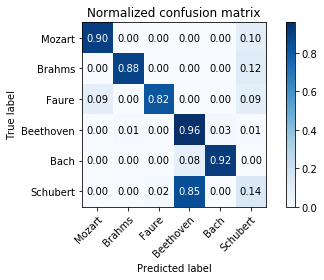

In [77]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=classes,
                      title='Normalized confusion matrix - STFT + MFC Spectrum CNN-LSTM Piano')

plt.show()

In [81]:
y_test = []
y_pred = []
for i in range(len(testing_generator)):
    x_test, y_test_ = testing_generator[i]
    y_pred_ = parallel_model.predict(x_test)
    y_test.append(y_test_.argmax(axis=1))
    y_pred.append(y_pred_.argmax(axis=1))
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

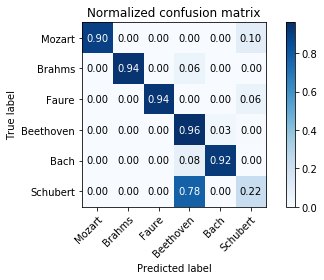

In [82]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=classes,
                      title='Normalized confusion matrix')

plt.show()

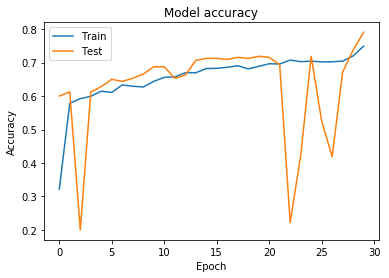

In [94]:
# Plot training & validation losses
plt.plot(historyMIX.history['acc'])
plt.plot(historyMIX.history['val_acc'])
plt.title('Model accuracy  - MFC Spectrum & STFT')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

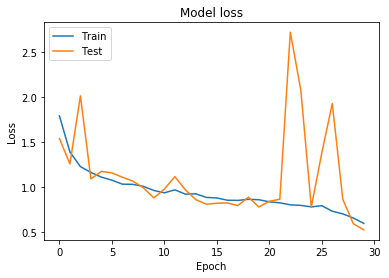

In [95]:
# Plot training & validation losses
plt.plot(historyMIX.history['loss'])
plt.plot(historyMIX.history['val_loss'])
plt.title('Model loss  - MFC Spectrum & STFT')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [85]:
accuracy_score(y_pred,y_test)

0.809375

In [80]:
parallel_model.save('mix_cnn_lstm.hd5')

0.790625